<font size="8"> **Categorising biological data using MEASO regions** </font>  
In this notebook, we will add a new category to the clean crabeater seal data, which will indicate the MEASO sector within which it was collected. We will obtain this information from the MEASO boundaries shapefile obtained from the [`measoshape`](https://australianantarcticdivision.github.io/measoshapes/) package for `R`.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading other relevant modules

In [1]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs

# Paralellising work 

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42441,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:34475,Total threads: 2
Dashboard: /proxy/34543/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:33347,


# Loading MEASO regions
Before using this shapefile we will need to apply a couple of corrections:
1. Remove any areas classified as *Temperate* because it is outside our area of interest
2. Remove duplicate *West Pacific Antarctic* polygons
  
Note that polygons for the `West Pacific` sector are already duplicated. This is because these areas straddle the international date line. However, when taking this into account, we still have an extra set of *West Pacific Antarctic* polygons that should be removed. We identify this by the different hex colour code used in the `fill` column.

In [70]:
#Loading MEASO shapefile
measo = gp.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo_wgs84.shp')

#Removing MEASO areas for temperate regions
measo = measo[measo.zone != "Temperate"]

#Removing duplicate WPA polygons - Removing based on name of sector and fill colour
measo = measo[(measo.fill != "#016074FF") | (measo.name != "WPA")].reset_index(drop = True)

#Checking results
measo

,name,sector,zone,fill,LongName,geometry
0,WPA,West Pacific,Antarctic,#BCECFEFF,West Pacific Antarctic,"POLYGON ((-180.00000 -64.70000, -166.00000 -64..."
1,WPS,West Pacific,Subantarctic,#1094AFFF,West Pacific Subantarctic,"POLYGON ((-125.00000 -65.20000, -128.00000 -65..."
2,WPN,West Pacific,Northern,#054e70FF,West Pacific Northern,"POLYGON ((-125.00000 -40.00000, -125.00000 -56..."
3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic,"POLYGON ((-125.00000 -85.00000, -125.00000 -65..."
4,EPS,East Pacific,Subantarctic,#5F9EA0FF,East Pacific Subantarctic,"POLYGON ((-125.00000 -65.20000, -125.00000 -56..."
5,EPN,East Pacific,Northern,#4B7D7EFF,East Pacific Northern,"POLYGON ((-125.00000 -56.80000, -125.00000 -40..."
6,AOA,Atlantic,Antarctic,#BCECFEFF,Atlantic Antarctic,"POLYGON ((-59.00000 -59.40791, -59.00000 -58.6..."
7,AOS,Atlantic,Subantarctic,#1094AFFF,Atlantic Subantarctic,"POLYGON ((30.00000 -56.50000, 28.00000 -56.500..."
8,AON,Atlantic,Northern,#054e70FF,Atlantic Northern,"POLYGON ((30.00000 -41.70000, 30.00000 -47.900..."
9,CIA,Central Indian,Antarctic,#FFFFFFFF,Central Indian Antarctic,"POLYGON ((30.00000 -85.00000, 30.00000 -56.500..."


MEASO has 5 sectors and 3 zones within each sector, which means that we should have 15 polygons. However, as noted above, the *West Pacific* areas are included twice because they straddle the international dateline. This means that our polygon should include 18 polygons in total.  

# Loading crabeater data
This is the dataset produced using the [02_Combining_data_all_sources]('02_Combining_data_all_sources.R') notebook. This dataset includes data from all publicly available sources. See the [01_Data_cleaning]('01_Data_cleaning') for more details on the data cleaning process.

In [74]:
#Loading dataset as pandas data frame
crabeaters = pd.read_csv('../Cleaned_Data/All_sources_clean_data.csv')

#Turning into geodataframe to perform spatial joint with MEASO shapefile
crab_obs_shp = gp.GeoDataFrame(crabeaters, 
                               geometry = gp.points_from_xy(crabeaters.longitude, 
                                                            crabeaters.latitude), 
                               crs = 'EPSG:4326')

#Checking results
crab_obs_shp.head()

,event_date,latitude,longitude,number_individuals,basis_record,year,month,season_year,life_stage,decade,geometry
0,2019-03-09T00:00:00Z,-64.9028,-62.8643,1,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-62.86430 -64.90280)
1,2019-03-13T00:00:00Z,-65.1413,-64.1443,10,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.14430 -65.14130)
2,2019-03-15T00:00:00Z,-65.1402,-64.0595,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.05950 -65.14020)
3,2019-03-15T00:00:00Z,-65.0977,-63.9802,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-63.98020 -65.09770)
4,2019-03-14T00:00:00Z,-65.3383,-64.1300,65,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.13000 -65.33830)


# Plotting MEASO regions and crabeater data
This step allows us to visualise we have loaded the data correctly. Both datasets should overlap.

<GeoAxesSubplot:>

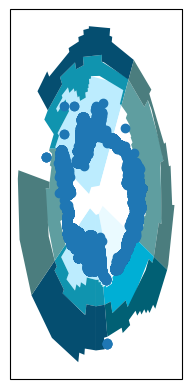

In [75]:
#Initialising figure
fig = plt.figure()

#Adding plot with South Polar Stereographic projection
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())

#Plotting MEASO regions and crabeaters data
measo.plot(ax = ax, color = measo['fill'], transform = ccrs.PlateCarree())
crab_obs_shp.plot(ax = ax, transform = ccrs.PlateCarree())

# Adding MEASO sector column to crabeater data
We will add this information by performing a spatial joint with every sector (that is, we will ignore the three latitudinal zones) within the MEASO shapefile.

In [76]:
#Creating empty list to store results
new_crab = []

#Looping through every sector
for s in measo.sector.unique():
    sector = measo[measo.sector == s]
    #Performing spatial joint
    pts = gp.sjoin(crab_obs_shp, sector)
    #Adding result to empty list
    new_crab.append(pts)

Finally, we will turn the list we created in the previous step into a geodataframe.

In [77]:
new_crab = gp.pd.concat(new_crab).sort_index()
#Checking results
new_crab.head()

,event_date,latitude,longitude,number_individuals,basis_record,year,month,season_year,life_stage,decade,geometry,index_right,name,sector,zone,fill,LongName
0,2019-03-09T00:00:00Z,-64.9028,-62.8643,1,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-62.86430 -64.90280),3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic
1,2019-03-13T00:00:00Z,-65.1413,-64.1443,10,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.14430 -65.14130),3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic
2,2019-03-15T00:00:00Z,-65.1402,-64.0595,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.05950 -65.14020),3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic
3,2019-03-15T00:00:00Z,-65.0977,-63.9802,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-63.98020 -65.09770),3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic
4,2019-03-14T00:00:00Z,-65.3383,-64.1300,65,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.13000 -65.33830),3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic


## Plotting crabeater data with new category

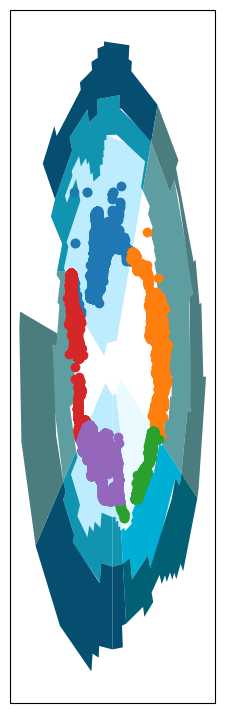

In [78]:
#Starting figure
fig = plt.figure(figsize = (3, 9))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())

#Plotting MEASO sectors
measo.plot(ax = ax, color = measo['fill'], transform = ccrs.PlateCarree())

#Plotting crabeater data. Color coding based on sectors
for k, g in new_crab.groupby('sector'):
    g.plot(ax = ax, label = k, transform = ccrs.PlateCarree())

The crabeater data has different colors based on the sector they are located, which is exactly what we needed. However, we have lost some points that were outside the MEASO boundaries. We can check how many points have been excluded.

In [79]:
print(len(new_crab) - len(crab_obs_shp))

-9


Our new data frame has nine less points than the original. We can check that these points are in fact outside the MEASO boundaries by performing an anti join (i.e., find the points that are not included in two datasets).

In [88]:
#Compare new and original crabeater data and mark points NOT present in both datasets
outer = new_crab.merge(crab_obs_shp, how = 'outer', indicator = True)

#The _merge column will mark the points only present in one dataset - Mark as either left or right only
outer[outer._merge.str.match('.*only')]

,event_date,latitude,longitude,number_individuals,basis_record,year,month,season_year,life_stage,decade,geometry,index_right,name,sector,zone,fill,LongName,_merge
154788,2021-05-01T00:00:00Z,-54.811450,-68.315413,1,HUMAN_OBSERVATION,2021,5,autumn,in-between,2020,POINT (-68.31541 -54.81145),NaN,NaN,NaN,NaN,NaN,NaN,right_only
154789,2020-02-21T00:00:00Z,-45.906955,170.548060,1,HUMAN_OBSERVATION,2020,2,summer,moulting,2020,POINT (170.54806 -45.90696),NaN,NaN,NaN,NaN,NaN,NaN,right_only
154790,2021-05-01T00:00:00Z,-54.811004,-68.315503,1,HUMAN_OBSERVATION,2021,5,autumn,in-between,2020,POINT (-68.31550 -54.81100),NaN,NaN,NaN,NaN,NaN,NaN,right_only
154791,2019-07-02T00:00:00Z,-45.645771,170.657196,1,HUMAN_OBSERVATION,2019,7,autumn,in-between,2010,POINT (170.65720 -45.64577),NaN,NaN,NaN,NaN,NaN,NaN,right_only
154792,2021-05-01T00:00:00Z,-54.811656,-68.315274,1,HUMAN_OBSERVATION,2021,5,autumn,in-between,2020,POINT (-68.31527 -54.81166),NaN,NaN,NaN,NaN,NaN,NaN,right_only
154793,2021-05-01T00:00:00Z,-54.811539,-68.315471,1,HUMAN_OBSERVATION,2021,5,autumn,in-between,2020,POINT (-68.31547 -54.81154),NaN,NaN,NaN,NaN,NaN,NaN,right_only
154794,2019-07-03T00:00:00Z,-45.645672,170.657378,1,HUMAN_OBSERVATION,2019,7,autumn,in-between,2010,POINT (170.65738 -45.64567),NaN,NaN,NaN,NaN,NaN,NaN,right_only
154795,2019-07-02T00:00:00Z,-45.645911,170.657495,1,HUMAN_OBSERVATION,2019,7,autumn,in-between,2010,POINT (170.65750 -45.64591),NaN,NaN,NaN,NaN,NaN,NaN,right_only
154796,2020-02-22T00:00:00Z,-45.906654,170.548249,1,HUMAN_OBSERVATION,2020,2,summer,moulting,2020,POINT (170.54825 -45.90665),NaN,NaN,NaN,NaN,NaN,NaN,right_only


Plotting the points not present in our new data frame over the MEASO sectors.

<GeoAxesSubplot:>

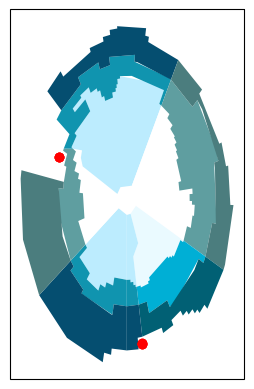

In [90]:
#Initialising figure
fig = plt.figure()
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())

#Plotting MEASO
measo.plot(ax = ax, color = measo['fill'], transform = ccrs.PlateCarree())

#Plotting points excluded in new data frame
outer[outer._merge.str.match('.*only')].plot(ax = ax, transform = ccrs.PlateCarree(),
                                            color = 'red')

# Saving new data frame to disk

Saving as CSV file.

In [93]:
new_crab.to_csv('../Cleaned_Data/All_sources_clean_data_MEASO.csv')

Saving as shapefile.

In [92]:
new_crab.to_file('../Cleaned_Data/All_sources_clean_data_MEASO.shp')

/jobfs/85903454.gadi-pbs/ipykernel_922292/3124838923.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  new_crab.to_file('../Cleaned_Data/All_sources_clean_data_MEASO.shp')
